In [1]:
import pandas as pd
import numpy as np

from scipy import stats

import seaborn as sns
sns.set(color_codes=True)

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

C:\Users\Abhishek\Anaconda2\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# load train and test files
train = pd.read_csv('./data/train.csv', parse_dates=['Original_Quote_Date'], index_col='QuoteNumber')
test = pd.read_csv('./data/test.csv', parse_dates=['Original_Quote_Date'], index_col='QuoteNumber')

In [3]:
# size of training and test set

print train.shape
print test.shape

(260753, 298)
(173836, 297)


In [4]:
train.columns

Index([u'Original_Quote_Date', u'QuoteConversion_Flag', u'Field6', u'Field7',
       u'Field8', u'Field9', u'Field10', u'Field11', u'Field12',
       u'CoverageField1A',
       ...
       u'GeographicField59A', u'GeographicField59B', u'GeographicField60A',
       u'GeographicField60B', u'GeographicField61A', u'GeographicField61B',
       u'GeographicField62A', u'GeographicField62B', u'GeographicField63',
       u'GeographicField64'],
      dtype='object', length=298)

In [5]:
# transform column names to lowercase

train.columns = train.columns.map(lambda x: x.lower())
test.columns = test.columns.map(lambda x: x.lower())

In [23]:
%run scripts/helper.py

In [7]:
# encode categorical features
train, test = encode_labels(train, test)

In [8]:
# convert the original_quote_date into year_original_quote_date,
# month_original_quote_date, quarter_original_quote_date and weekday
# and drop the original_quote_date feature

train['year_original_quote_date'] = train.original_quote_date.dt.year
train['month_original_quote_date'] = train.original_quote_date.dt.month
train['quarter_original_quote_date'] = train.original_quote_date.dt.quarter
train['weekday_original_quote_date'] = train.original_quote_date.dt.weekday

test['year_original_quote_date'] = test.original_quote_date.dt.year
test['month_original_quote_date'] = test.original_quote_date.dt.month
test['quarter_original_quote_date'] = test.original_quote_date.dt.quarter
test['weekday_original_quote_date'] = test.original_quote_date.dt.weekday

train = train.drop('original_quote_date', axis=1)
test = test.drop('original_quote_date', axis=1)

In [9]:
# drop columns with constant values

train = train.drop('propertyfield6', axis=1)
train = train.drop('geographicfield10a', axis=1)

test = test.drop('propertyfield6', axis=1)
test = test.drop('geographicfield10a', axis=1)

In [10]:
# fill missing value with -1 to indicate that this is a missing value

train = train.fillna(-1)
test = test.fillna(-1)

In [11]:
# take stratified sample from the dataset ( only 5% of the total examples )
train_sample = get_stratified_sample(train, train.quoteconversion_flag, percentage=0.05)

In [12]:
# separate features and target variable
train_features = train_sample[train_sample.columns.drop('quoteconversion_flag')]
target = train_sample.quoteconversion_flag

test_features = test

In [13]:
# size of the samples
train_features.shape

(13037, 298)

In [14]:
# divide into training and test set
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_features, target, test_size=0.3, random_state=0)

In [15]:
# shape of X_train and X_test
print X_train.shape, X_test.shape

(9125, 298) (3912, 298)


In [16]:
# Stratified K Fold settings

from sklearn.cross_validation import StratifiedKFold, cross_val_score
skf = StratifiedKFold(y_train, 3)

In [17]:
import xgboost as xgb

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

In [21]:
xgb_clf = xgb.XGBClassifier()
rf_clf = RandomForestClassifier()

In [24]:
# tuning hyperparameters for extreme gradient boosting algorithm
parameters = dict([('n_estimators', [75, 150]), ('learning_rate', [.03, .01, 0.08]), ('max_depth', [8, 10]),
               ('min_child_weight', [5, 10]), ('subsample', [0.8]), ('colsample_bytree', [0.8])])

tuned_xgb_clf = cv_optimize(X_train, y_train, skf, xgb_clf, parameters)

print 'best score {} and best classifier \n {} '.format(tuned_xgb_clf.best_score_, tuned_xgb_clf.best_estimator_)

best score 0.959115884966 and best classifier 
 XGBClassifier(base_score=0.5, colsample_bytree=0.8, gamma=0,
       learning_rate=0.03, max_delta_step=0, max_depth=10,
       min_child_weight=5, missing=None, n_estimators=150, nthread=-1,
       objective='binary:logistic', seed=0, silent=True, subsample=0.8) 


In [27]:
# tuning hyperparameters for random forest classifier

parameters = dict([('n_estimators', [100, 150]), ('criterion', ['gini', 'entropy']), ('min_samples_split', [2, 4]),
                   ('min_samples_leaf', [1, 3]), ('class_weight', [None, 'auto'])])

tuned_rf_clf = cv_optimize(X_train, y_train, skf, rf_clf, parameters)
print 'best score {} and best classifier \n {} '.format(tuned_rf_clf.best_score_, tuned_rf_clf.best_estimator_)

best score 0.943722044538 and best classifier 
 RandomForestClassifier(bootstrap=True, class_weight='auto',
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) 


In [29]:
# let's see how these two finely tuned classifiers perform on the unseen examples
from sklearn.metrics import roc_auc_score

predict_xgb = tuned_xgb_clf.best_estimator_.predict_proba(X_test)[:, 1]
predict_rf = tuned_rf_clf.best_estimator_.predict_proba(X_test)[:, 1]

xgb_auc = roc_auc_score(y_test, predict_xgb)
rf_auc = roc_auc_score(y_test, predict_rf)

print 'AUC score for Xgboost model {} \nAUC score for Random Forest Model {} '.format(xgb_auc, rf_auc)

AUC score for Xgboost model 0.950654161412 
AUC score for Random Forest Model 0.931546513411 


In [32]:
# lets take average of the two predictions and see if it improves overall accuracy on the 
# unseen examples

predict_ensemble = 0.5 * predict_xgb + predict_rf * 0.5

ensemble_auc = roc_auc_score(y_test, predict_ensemble)

print 'AUC score after taking average of the two predictions {} '.format(ensemble_auc)

AUC score after taking average of the two predictions 0.950356582939 


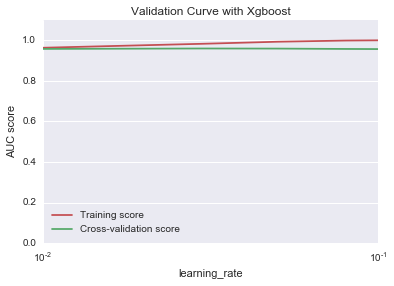

In [33]:
# lets plot validation curve to see the effect of changing learning rate on the Xgboost model

from sklearn.learning_curve import validation_curve

param_range = [0.1, 0.08, 0.05, 0.03, 0.01]
train_scores, test_scores = validation_curve(
    xgb.XGBClassifier(n_estimators=500), X_train, y_train, param_name="learning_rate", param_range=param_range,
    cv=skf, scoring="roc_auc", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Xgboost")
plt.xlabel("learning_rate")
plt.ylabel("AUC score")
plt.ylim(0.0, 1.1)
plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

In [34]:
# different Xgboost models
xgb_clf_1 = xgb.XGBClassifier(n_estimators=500, max_depth=10, learning_rate=0.01, min_child_weight=5, colsample_bytree=0.8, subsample=0.8)

In [35]:
# cross validating Extreme Gradient Classifier on 5% of training examples
scores = cross_val_score(xgb_clf_1, X_train, y_train, scoring='roc_auc', cv=skf)
print 'Min score {}, Mean score {} and Max score {} '.format(scores.min(), scores.mean(), scores.max())

Min score 0.957363966624, Mean score 0.959451204182 and Max score 0.962442975687 


In [36]:
xgb_clf_2 = xgb.XGBClassifier(n_estimators=75, max_depth=8, learning_rate=0.1, min_child_weight=5, colsample_bytree=0.6, subsample=0.6)

In [37]:
# cross validating Extreme Gradient Classifier on 5% of training examples
scores = cross_val_score(xgb_clf_2, X_train, y_train, scoring='roc_auc', cv=skf)
print 'Min score {}, Mean score {} and Max score {} '.format(scores.min(), scores.mean(), scores.max())

Min score 0.953332611927, Mean score 0.956699424304 and Max score 0.959408798118 


In [38]:
# train these two models on the training set
xgb_clf_1.fit(X_train, y_train)
xgb_clf_2.fit(X_train, y_train)

AUC score clf 1 0.951913278348 
AUC score clf 2 0.948753024778
 AUC score ensemble 0.951300654374


In [39]:
pred_clf_1 = xgb_clf_1.predict_proba(X_test)[:, 1]
pred_clf_2 = xgb_clf_2.predict_proba(X_test)[:, 1]

ensemble_preds = 0.7 * pred_clf_1 + pred_clf_2 * 0.3

roc_auc_score_1 = roc_auc_score(y_test, pred_clf_1)
roc_auc_score_2 = roc_auc_score(y_test, pred_clf_2)
roc_auc_score_ensemble = roc_auc_score(y_test, ensemble_preds)

print 'AUC score clf 1 {} \nAUC score clf 2 {}\n AUC score ensemble {}'.format(roc_auc_score_1, roc_auc_score_2, roc_auc_score_ensemble)

AUC score clf 1 0.951913278348 
AUC score clf 2 0.948753024778
 AUC score ensemble 0.951817422719


In [20]:
# cross validation Random Forest Classifier on 5% of training examples
scores = cross_val_score(RandomForestClassifier(), X_train, y_train, scoring='roc_auc', cv=skf)
print 'Min score {}, Mean score {} and Max score {} '.format(scores.min(), scores.mean(), scores.max())

Min score 0.896716937289, Mean score 0.906615145821 and Max score 0.91615005439 


In [ ]:
# create submission file
submission = pd.read_csv('./data/sample_submission.csv')
submission['QuoteConversion_Flag'] = predictions
submission.to_csv('./submissions/tenth_submission.csv', index=False)